# Credit Card Customer Churn EDA & Prediction

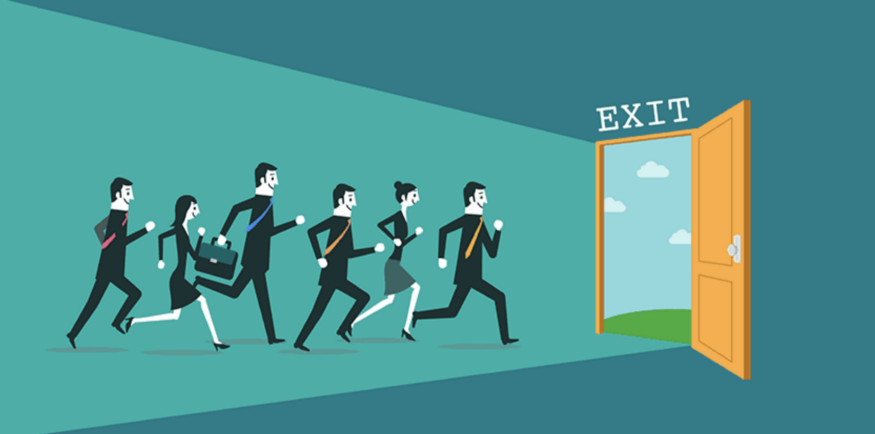

# 1. Introduction

Customer attrition, also known as customer churn, customer turnover, or customer defection, is the loss of clients or customers.

Banks, telephone service companies, Internet service providers, pay TV companies, insurance firms, and alarm monitoring services, often use customer attrition analysis and customer attrition rates as one of their key business metrics (along with cash flow, EBITDA, etc.) because the cost of retaining an existing customer is far less than acquiring a new one.[1] Companies from these sectors often have customer service branches which attempt to win back defecting clients, because recovered long-term customers can be worth much more to a company than newly recruited clients. https://en.wikipedia.org/wiki/Customer_attrition

# 2. Importing Libraries and Dataset

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df=pd.read_csv('/kaggle/input/credit-card-customers/BankChurners.csv')
df.head()

In [ ]:
cols = np.arange(21,df.shape[1])
df.drop(df.columns[cols],axis=1,inplace=True)
df.describe()

# 3. Exploratory Data Analysis

## 3.1 Based On Frequency of Use and Numeral Characteristics

In [ ]:
df_frequency=pd.concat([df['Customer_Age'],df['Total_Trans_Ct'],df['Total_Trans_Amt'],df['Months_Inactive_12_mon'],df['Credit_Limit'],df['Attrition_Flag']],axis=1)
fig,ax=plt.subplots(ncols=4,figsize=(20,5))
sns.scatterplot(data=df_frequency,y="Total_Trans_Ct",x="Total_Trans_Amt",hue="Attrition_Flag",ax=ax[0])
sns.scatterplot(data=df_frequency,y="Total_Trans_Ct",x="Months_Inactive_12_mon",hue="Attrition_Flag",ax=ax[1])
sns.scatterplot(data=df_frequency,y="Total_Trans_Ct",x="Credit_Limit",hue="Attrition_Flag",ax=ax[2])
_scat=sns.scatterplot(data=df_frequency,y="Total_Trans_Ct",x="Customer_Age",hue="Attrition_Flag",ax=ax[3])

We see clearly above that we for all 4 features, we can point out the following hypothesis:
1. The higher they spend annually, the customers are more likely to remain.
2. After 2-3 months of inactivity, the customers are more likely to leave.
3. The higher the credit limit is, the customers are more likely to remain.
4. Age distribution does not really matter in this case, because the clusters are largely overlapped.
5. Almost all churned customers used their cards below 100 times.

## 3.2 Based On Demographics

In [ ]:
df_demographic=pd.concat([df['Customer_Age'],df['Gender'],df['Education_Level'],df['Marital_Status'],df['Income_Category'],df['Attrition_Flag']],axis=1)

In [ ]:
fig,(ax, ax2, ax3, ax4)=plt.subplots(ncols=4,figsize=(20,5))
pd.crosstab(df['Attrition_Flag'],df['Gender']).plot(kind='bar',ax=ax, ylim=[0,5000])
pd.crosstab(df['Attrition_Flag'],df['Education_Level']).plot(kind='bar',ax=ax2, ylim=[0,5000])
pd.crosstab(df['Attrition_Flag'],df['Marital_Status']).plot(kind='bar',ax=ax3, ylim=[0,5000])
pd.crosstab(df['Attrition_Flag'],df['Income_Category']).plot(kind='bar',ax=ax4, ylim=[0,5000])

fig,(ax, ax2, ax3)=plt.subplots(ncols=3,figsize=(20,5))
pd.crosstab(df['Attrition_Flag'],df['Dependent_count']).plot(kind='bar',ax=ax, ylim=[0,5000])
pd.crosstab(df['Attrition_Flag'],df['Card_Category']).plot(kind='bar',ax=ax2, ylim=[0,10000])
_box=sns.boxplot(data = df_demographic,x='Attrition_Flag',y='Customer_Age', ax=ax3)

While the figures indeed show some disparity in numbers between churned and existing customers, the distribution of each category is very similar. Also to support the claims of previous figure, we see again that age does not play a major factor in churned and existing customers.

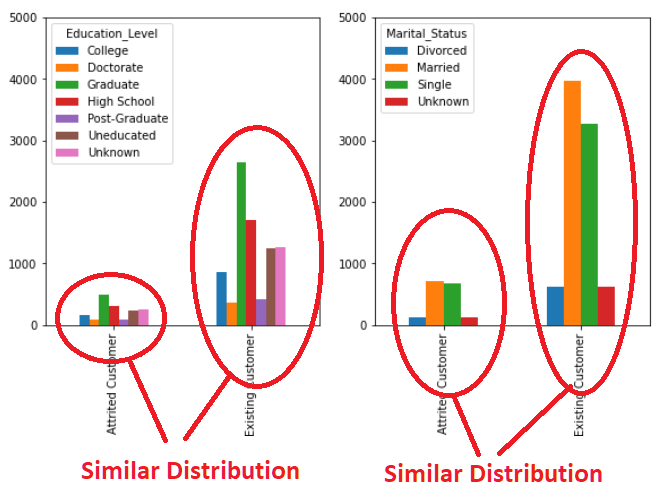

Meaning: 
The figures above shows that each category cannot be used alone as a factor to decide customer churn.
A married female with higher income and education is a different demographic than a single female with medium income and education.
As such, we will need to weigh in all these features to build our model.

# 4. Feature Engineering and Selection
## 4.1 Balance/Imbalance

First we check the event ratio of the dataset.

In [ ]:
churn=df['Attrition_Flag'].value_counts()
churn
_piechart=plt.pie(x=churn,labels=churn.keys(),autopct="%.1f%%")

Not a great ratio to have. This shows an imbalance in the dataset which can result in predictors making false positives/negatives because the attrition data is undersampled. We will need to counter this issue later when building our model.

## 4.2 Correlation

Since we have a dataset with mixed features: categorical and numerical, we cannot simply use standard correlation function (Pearson coefficient). We will have to split the features into separate tables, and we measure numerical data correlation via Pearson, and categorical data via Cramer's V function.

In [ ]:
df_categorical=df.loc[:,df.dtypes==np.object]
df_categorical = df_categorical[['Gender', 'Education_Level', 'Marital_Status', 'Income_Category','Card_Category','Attrition_Flag']]
df_categorical.head()

In [ ]:
df_numerical=df.loc[:,df.dtypes!=np.object]
df_numerical['Attrition_Flag']=df.loc[:,'Attrition_Flag']
oh=pd.get_dummies(df_numerical['Attrition_Flag'])
df_numerical=df_numerical.drop(['Attrition_Flag'],axis=1)
df_numerical=df_numerical.drop(['CLIENTNUM'],axis=1)
df_numerical=df_numerical.join(oh)
df_numerical.head()

In [ ]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
df_categorical_encoded = pd.DataFrame() 

for i in df_categorical.columns :
  df_categorical_encoded[i]=label.fit_transform(df_categorical[i])

from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

rows= []

for var1 in df_categorical_encoded:
  col = []
  for var2 in df_categorical_encoded :
    cramers =cramers_V(df_categorical_encoded[var1], df_categorical_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
cramerv_matrix = pd.DataFrame(cramers_results, columns = df_categorical_encoded.columns, index =df_categorical_encoded.columns)
mask = np.triu(np.ones_like(cramerv_matrix, dtype=np.bool))
cat_heatmap = sns.heatmap(cramerv_matrix, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
cat_heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

We see here that the categorical columns are NOT CORRELATED with customer churn by themselves. This supports the previous figures that show similar distribution between existing and churned customers across all demographic. Building an accurate model without considering the numerical values is impossible.

Now let's check the correlation of the numerical values.

In [ ]:
##Point Biserial Correlation
from scipy import stats
num_corr=df_numerical.corr()
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(num_corr, dtype=np.bool))
num_heatmap = sns.heatmap(num_corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
num_heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

We now see better correlation measurements to the customer churn. In the heatmap above, the correlation coefficient of attrited and existing customer to all feature columns are identical in numbers, with mirroring signs (+ and -).
Let's view them better:

In [ ]:
fig, ax=plt.subplots(ncols=2,figsize=(15, 5))

heatmap = sns.heatmap(num_corr[['Existing Customer']].sort_values(by='Existing Customer', ascending=False), ax=ax[0],vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Existing Customers', fontdict={'fontsize':18}, pad=16);
heatmap = sns.heatmap(num_corr[['Attrited Customer']].sort_values(by='Attrited Customer', ascending=False), ax=ax[1],vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Attrited Customers', fontdict={'fontsize':18}, pad=16);

fig.tight_layout(pad=5)

We see above that the following features are not correlated with customer churn (between -0.1 and +0.1) :
1. Credit Limit
2. Average Open To Buy
3. Months On Book
4. Age
5. Dependent Count

## 4.3 Removing Non-Correlating Columns

We discard the features mentioned above to build an accurate model.

In [ ]:
df_model=df
df_model=df_model.drop(['CLIENTNUM','Credit_Limit','Customer_Age','Avg_Open_To_Buy','Months_on_book','Dependent_count'],axis=1)
df_model.head()

## 4.4 One Hot Encoding

Now we convert the categorical features into binary with one hot encoding

In [ ]:
df_model['Attrition_Flag'] = df_model['Attrition_Flag'].map({'Existing Customer': 1, 'Attrited Customer': 0})
df_oh=pd.get_dummies(df_model)
df_oh['Attrition_Flag'] = df_oh['Attrition_Flag'].map({1: 'Existing Customer', 0: 'Attrited Customer'})
list(df_oh.columns)

# 5. Model Training

Now we train different classifiers and try to obtain the most accurate model.
We will utilize:
1. Random Forest
2. Support Vector Machine
3. Gradient Boosting

## 5.1 Balancing the Training Dataset

Before we train our prediction model, we will have to tinker with our imbalanced dataset first.
In section 4.1 we see that churned customer takes only 16.1% of the data.

To balance the dataset, we will utilize SMOTE.
SMOTE (Synthetic Minority Oversampling Technique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

First we split our training and test data. SMOTE will be applied only to training dataset so that the prediction will use original dataset with no synthetic datapoints.

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df_oh.loc[:, df_oh.columns != 'Attrition_Flag']
y = df_oh['Attrition_Flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
sm = SMOTE(sampling_strategy='minority', k_neighbors=20, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

## 5.2 Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_res, y_train_res)

## 5.3 Support Vector Machine

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
svm_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm_clf.fit(X_train_res, y_train_res)

## 5.4 Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf=GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=42)
gb_clf.fit(X_train_res, y_train_res)

# 6. Prediction Models

## 6.1 First Prediction

In [ ]:
y_rf=rf_clf.predict(X_test)
y_svm=svm_clf.predict(X_test)
y_gb=gb_clf.predict(X_test)

## 6.2 First Evaluation

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig,ax=plt.subplots(ncols=3, figsize=(20,6))
plot_confusion_matrix(rf_clf, X_test, y_test, ax=ax[0])
ax[0].title.set_text('Random Forest')
plot_confusion_matrix(svm_clf, X_test, y_test, ax=ax[1])
ax[1].title.set_text('Support Vector Machine')
plot_confusion_matrix(gb_clf, X_test, y_test, ax=ax[2])
ax[2].title.set_text('Gradient Boosting')
fig.tight_layout(pad=5)

In [ ]:
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
print('Random Forest Classifier')
print(classification_report(y_test, y_rf))
print('------------------------')
print('Support Vector Machine')
print(classification_report(y_test, y_svm))
print('------------------------')
print('Gradient Boosting')
print(classification_report(y_test, y_gb))

We see in both the confusion matrix and classification report that random forest and gradient boosting works best with recall score above 85%.

## 6.3 Tuning Hyperparameters

Now we will attempt to raise the model accuracy even more. We can achieve this by tuning the algorithm hyperparameters. Since SVM produced very low accuracy (<60%), we will not consider this algorithm any further.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
#rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_train_res, y_train_res)
#print(rf_random.best_params_)

In [ ]:
rf_clf_opt= RandomForestClassifier(n_estimators=750, min_samples_split=2, min_samples_leaf=1, 
                            max_features='auto', max_depth=50, bootstrap=False)
rf_clf_opt.fit(X_train_res,y_train_res)
y_rf_opt=rf_clf_opt.predict(X_test)
print('Random Forest Classifier (Optimized)')
print(classification_report(y_test, y_rf_opt))
_rf_opt=plot_confusion_matrix(rf_clf_opt, X_test, y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_test1 = {'n_estimators':range(20,81,10)}
#gsearch1 = GridSearchCV(
#estimator = GradientBoostingClassifier(learning_rate=1.0, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
#param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
#gsearch1.fit(X_train_res,y_train_res)
#print(gsearch1.best_params_)

In [ ]:
gb_clf_opt=GradientBoostingClassifier(n_estimators=80,learning_rate=1.0, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10)
gb_clf_opt.fit(X_train_res,y_train_res)
y_gb_opt=gb_clf_opt.predict(X_test)
print('Gradient Boosting (Optimized)')
print(classification_report(y_test, y_gb_opt))
print(recall_score(y_test,y_gb_opt,pos_label="Attrited Customer"))
_gbopt=plot_confusion_matrix(gb_clf_opt, X_test, y_test)

# 7. Conclusion

After tuning the hyperparameters and reevaluating, there were no significant change to the recall score and accuracy.
However, the model can be considered good enough as it is 95% accurate and has 84% recall score.

Notebook Banner Image Source: https://miro.medium.com/max/875/1*k0aH2ikjVKpXNOIDFKXdTg.png